In [2]:
import tensorflow as tf
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tf.random.set_seed(42)

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1974128529192338571
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4160159744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17832455615319640594
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) # angka 1 dibelakang menunjukkan color channel. Hanya ada 1 color channel
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

In [6]:
#setting several important parameters
epochs = 5
batch_size = 250

l2_norm_clip = 1.5
noise_multiplier = 1.6 #2 results in [0.78,0.773], 1.6 results in [0.633, 0.649], 1.3 results in [0.522,0.523]
num_microbatches = 50
learning_rate = 0.25

#sanity check
if batch_size % num_microbatches != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


# DIFFERENTIAL PRIVACY

### First Model (Apply Noise to DP-SGD)

In [7]:
# we use CNN to fit to the dataset

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,8,
                          strides = 2,
                          padding = 'same',
                          activation = 'relu',
                          input_shape = (28,28,1)),
    tf.keras.layers.MaxPool2D(2,1),
    tf.keras.layers.Conv2D(32,4,
                          strides = 2,
                          padding = 'valid',
                          activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip = l2_norm_clip,
    noise_multiplier = noise_multiplier,
    num_microbatches = num_microbatches,
    learning_rate = learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits = False, reduction = tf.losses.Reduction.NONE)


In [8]:
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
model.fit(train_data, train_labels,
         epochs = epochs,
         validation_data = (test_data, test_labels),
          batch_size = batch_size)

Epoch 1/5
240/240 [==============================] - 29s 99ms/step - loss: 1.0116 - accuracy: 0.6881 - val_loss: 0.9191 - val_accuracy: 0.8046
Epoch 2/5
240/240 [==============================] - 24s 99ms/step - loss: 1.0268 - accuracy: 0.8079 - val_loss: 1.1657 - val_accuracy: 0.7998
Epoch 3/5
240/240 [==============================] - 24s 102ms/step - loss: 1.1985 - accuracy: 0.7785 - val_loss: 1.2780 - val_accuracy: 0.7796
Epoch 4/5
240/240 [==============================] - 24s 102ms/step - loss: 1.3780 - accuracy: 0.7881 - val_loss: 1.2678 - val_accuracy: 0.7973
Epoch 5/5
240/240 [==============================] - 24s 101ms/step - loss: 1.2967 - accuracy: 0.7592 - val_loss: 1.1354 - val_accuracy: 0.7695


In [9]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=noise_multiplier,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1.6 iterated over 1200 steps satisfies differential privacy with eps = 0.422 and delta = 1e-05.
The optimal RDP order is 27.0.


(0.4223191547406633, 27.0)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        1040      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 32)                1

In [11]:
from keras import backend as K

# with a Sequential model
get_5th_output = K.function([model.layers[0].input],
                                  [model.layers[5].output])
layer_output = get_5th_output([train_data])[0]
layer_output[:10]

array([[0.0000000e+00, 1.4647511e+01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.5145994e+01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.0982635e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.9871269e+01],
       [0.0000000e+00, 2.1325281e+01, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 5.3824329e-01, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.5360462e+01,
        0.0000000e+00, 0.0000000e+00, 0.0000000

### Second Model (No Noise Model)

In [12]:
modelnonoise = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,8,
                          strides = 2,
                          padding = 'same',
                          activation = 'relu',
                          input_shape = (28,28,1)),
    tf.keras.layers.MaxPool2D(2,1),
    tf.keras.layers.Conv2D(32,4,
                          strides = 2,
                          padding = 'valid',
                          activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(10,activation = 'softmax')
])

optimizernonoise = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip = l2_norm_clip,
    noise_multiplier = 1,
    num_microbatches = num_microbatches,
    learning_rate = learning_rate)
lossnonoise = tf.keras.losses.CategoricalCrossentropy(
    from_logits = False, reduction = tf.losses.Reduction.NONE)


In [13]:
modelnonoise.compile(optimizer = optimizernonoise, loss = lossnonoise, metrics = ['accuracy'])
modelnonoise.fit(train_data, train_labels,
         epochs = epochs,
         validation_data = (test_data, test_labels),
          batch_size = batch_size)

Epoch 1/5
240/240 [==============================] - 25s 97ms/step - loss: 0.7729 - accuracy: 0.7588 - val_loss: 0.4096 - val_accuracy: 0.8901
Epoch 2/5
240/240 [==============================] - 24s 100ms/step - loss: 0.4368 - accuracy: 0.8991 - val_loss: 0.4301 - val_accuracy: 0.9096
Epoch 3/5
240/240 [==============================] - 24s 99ms/step - loss: 0.5188 - accuracy: 0.9028 - val_loss: 0.5725 - val_accuracy: 0.9078
Epoch 4/5
240/240 [==============================] - 23s 96ms/step - loss: 0.7262 - accuracy: 0.9009 - val_loss: 0.7671 - val_accuracy: 0.9019
Epoch 5/5
240/240 [==============================] - 23s 95ms/step - loss: 0.8906 - accuracy: 0.8957 - val_loss: 0.8770 - val_accuracy: 0.8988


In [14]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=1,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 10.0.


(1.1278495014370558, 10.0)

In [15]:
get_5th_output_noise = K.function([modelnonoise.layers[0].input],
                                  [modelnonoise.layers[5].output])
layer_output_noise = get_5th_output_noise([train_data])[0]
print(layer_output_noise[:10])

[[ 0.         37.934723   11.027269    0.          0.          5.0261617
   0.          0.          0.          0.         17.378935   48.611473
  26.775843    0.         11.039962   26.12334     0.         57.693638
  11.910622    2.798961   29.658113   18.878159    0.         30.037392
   0.         15.742352   15.848931    0.          0.          0.
   0.          9.203151  ]
 [25.455784    0.          3.902671    0.          0.         38.46784
   0.          5.318727    0.          0.         14.388587   34.3807
  27.172813   20.608511   20.419807    0.          0.         42.31831
   4.626705   29.034191    0.5917217  12.261723    0.         20.24391
  17.237755   15.6719475  37.179928    0.         10.847564    0.
   0.         39.380257  ]
 [ 7.547134    0.          0.          0.          0.         17.856714
   0.          0.          0.80232537  0.          1.8289713   0.
   0.          0.          0.          1.4398093   0.          4.9746294
   0.          9.095232   17.05

In [16]:
eps, rdp = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=batch_size,
                                              noise_multiplier=1,
                                              epochs=epochs,
                                              delta=1e-5)

DP-SGD with sampling rate = 0.417% and noise_multiplier = 1 iterated over 1200 steps satisfies differential privacy with eps = 1.13 and delta = 1e-05.
The optimal RDP order is 10.0.


# GAN to Evaluate

In [17]:
def discriminator(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*2,input_dim = in_shape,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def discriminator2(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*2,input_dim = in_shape,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def generator(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape/2,input_dim = in_shape,activation = 'relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8,activation = 'relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(in_shape,activation = 'linear')
    ])
    #optimizer = tf.keras.optimizers.Adam()
    #model.compile(loss = 'binary_crossentropy',optimizer = optimizer,
    #             metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model
    
def GAN(gen,dis):
    dis.trainable = False
    model = tf.keras.Sequential([ 
        gen,
        dis
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model

def generate_fake_samples(gen, data, batch):
    x_input = np.random.randn(batch,data.shape[1])
    x = gen.predict(x_input)
    y = np.zeros((batch,1))
    
    return x,y

def train(gen, dis, dis2, gan, withnoise, nonoise, n_epochs= 10000, n_batch = 512):
    #determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch/2)
    dishist=[]
    genhist=[]
    disacchist = []
    dis2acchist = []
    
    #initialize model true discriminator first time
    dis2_nonoise_train_x = nonoise[:]
    dis2_nonoise_train_y = np.ones((nonoise.shape[0],1))
    
    dis2_withnoise_train_x = withnoise[:]
    dis2_withnoise_train_y = np.zeros((withnoise.shape[0],1))
    
    dis2x = pd.DataFrame(dis2_nonoise_train_x).append(pd.DataFrame(dis2_withnoise_train_x),ignore_index = True).to_numpy()
    dis2y = pd.DataFrame(dis2_nonoise_train_y).append(pd.DataFrame(dis2_withnoise_train_y),ignore_index = True).to_numpy()
    
    dis2.fit(dis2x,dis2y)
    #manually enumerate epochs
    for epoch in range(n_epochs):
        #prepare samples      
        #data with noise
        x_real = withnoise[np.random.choice(withnoise.shape[0], half_batch, replace=False), :]
        y_real = np.ones((half_batch,1))
        
        #data with noise upsampled
        x_fake, y_fake = generate_fake_samples(gen, withnoise, half_batch)
        
        #data with noise + with noise upsampled
        disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
        disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
        
        ###########################################################################################################      
        ##GAN PART
        #update discriminator
        disloss, disacc = dis.train_on_batch(disx,disy)
        
        #input for gan
        noise = np.random.randn(n_batch,withnoise.shape[1])
        y_gen = np.ones((n_batch,1))
        
        #update generator from discriminator error
        gen_loss_fake = gan.train_on_batch(noise,y_gen)
        
        ###########################################################################################################
        ##2ND DISCRIMINANT PART
        #check dis2 performance
        #data noise + noise upsampled 
        dis2_noise_x = disx[:]
        dis2_noise_y = disy[:]
        dis2_noise_y[:] = 0
    
        #data no noise
        dis2_nonoise_x = nonoise[np.random.choice(nonoise.shape[0], dis2_noise_x.shape[0], replace=False), :]
        dis2_nonoise_y = np.ones((dis2_noise_y.shape[0],1))
        
        #aggregated
        dis2x_test = pd.DataFrame(dis2_nonoise_x).append(pd.DataFrame(dis2_noise_x),ignore_index = True).to_numpy()
        dis2y_test = pd.DataFrame(dis2_nonoise_y).append(pd.DataFrame(dis2_noise_y),ignore_index = True).to_numpy()
        
        dis2loss, dis2acc = dis2.test_on_batch(dis2x_test,dis2y_test)
        
        print('>%d, discriminant_loss=%.3f discriminant_acc=%.3f generator_loss=%.3f true_discriminant_acc=%.3f' % (epoch+1, disloss, disacc, gen_loss_fake, dis2acc))
        
        dishist.append(disloss)
        genhist.append(gen_loss_fake)
        disacchist.append(disacc)
        dis2acchist.append(dis2acc)
    plot_history(dishist,genhist,disacchist,dis2acchist)
    
    #final accuracy of True Discriminant
    noiseupsampled_x, noiseupsampled_y = generate_fake_samples(gen, withnoise, half_batch)
    withnoise_x, withnoise_y = withnoise[:], np.zeros((withnoise.shape[0],1))
    noise_x = pd.DataFrame(noiseupsampled_x).append(pd.DataFrame(withnoise_x),ignore_index = True).to_numpy()
    noise_y = pd.DataFrame(noiseupsampled_y).append(pd.DataFrame(withnoise_y),ignore_index = True).to_numpy()
    
    nonoise_x, nonoise_y = nonoise[:], np.ones((nonoise.shape[0],1))
    
    dis2x_final = pd.DataFrame(noise_x).append(pd.DataFrame(nonoise_x),ignore_index = True).to_numpy()
    dis2y_final = pd.DataFrame(noise_y).append(pd.DataFrame(nonoise_y),ignore_index = True).to_numpy()
    
    fin_loss, fin_acc = dis2.test_on_batch(dis2x_final, dis2y_final)
    
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
        

def plot_history(d_hist, g_hist, dacc_hist, dacc2_hist):
    # plot loss    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(d_hist, label='discriminator_loss')
    plt.plot(g_hist, label='generator_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.subplot(212)
    plt.plot(dacc_hist, label='GAN_discriminator_accuracy')
    plt.plot(dacc2_hist, label='True_discriminator_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()
    plt.close()
    

In [18]:
predprobnoise = model.predict(train_data)
predprobtrue = modelnonoise.predict(train_data)

1875/1875 [==============================] - 5s 2ms/step


In [19]:
disc2 = discriminator2(predprobtrue.shape[1])
disc = discriminator(predprobnoise.shape[1])
gen = generator(predprobnoise.shape[1])
gan = GAN(gen,disc)

In [20]:
#Sanity check for discriminator before running
#x_real = predprobtrue
#y_real = np.ones((predprobtrue.shape[0],1))
#x_fake = predprobnoise
#y_fake = np.zeros((predprobnoise.shape[0],1))
#        
#disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
#disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
#        
#check how well discriminant seperate model
#xgen,ygen = generate_fake_samples(gen, predprobnoise, predprobnoise.shape[0])
#disc.fit(disx,disy)
#dispred = disc.predict(xgen)

#from sklearn.metrics import accuracy_score

#disacc = accuracy_score(ygen,np.where(dispred>0.5,1,0))
#print(disacc)

In [21]:
#Sanity check for the Generator model
#to check whether generated sample after training is different than the previous or not
np.random.seed(42)
noise = np.random.randn(6000,10)
genbefore = gen.predict(noise)

188/188 [==============================] - 0s 2ms/step


In [22]:
genbefore

array([[-0.16436289, -0.70492744,  0.33264112, ..., -0.44798952,
         0.06580706, -0.06491663],
       [ 0.09769053, -0.2259385 , -0.26077178, ..., -0.12995565,
        -0.09684958,  0.2576469 ],
       [-0.03165211, -0.0650923 , -0.0879971 , ..., -0.15278049,
         0.01420762,  0.11631089],
       ...,
       [-0.05054653, -0.65187   , -0.31911266, ..., -0.8572191 ,
         0.11678249,  0.46597114],
       [-0.11188108, -1.0339772 , -0.2921688 , ..., -1.3024745 ,
         0.17348185,  0.6384599 ],
       [-0.02587834, -0.24829769,  0.01126804, ..., -0.20305708,
         0.01278465,  0.04876039]], dtype=float32)

C:\Windows\Temp\ipykernel_15832\2783495971.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis2x = pd.DataFrame(dis2_nonoise_train_x).append(pd.DataFrame(dis2_withnoise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis2y = pd.DataFrame(dis2_nonoise_train_y).append(pd.DataFrame(dis2_withnoise_train_y),ignore_index = True).to_numpy()


8/8 [==============================] - 0s 2ms/step


C:\Windows\Temp\ipykernel_15832\2783495971.py:87: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:115: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis2x_test = pd.DataFrame(dis2_nonoise_x).append(pd.DataFrame(dis2_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:116: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

>1, discriminant_loss=0.700 discriminant_acc=0.549 generator_loss=0.625 true_discriminant_acc=0.592
8/8 [==============================] - 0s 2ms/step
>2, discriminant_loss=0.711 discriminant_acc=0.553 generator_loss=0.629 true_discriminant_acc=0.597
8/8 [==============================] - 0s 2ms/step
>3, discriminant_loss=0.700 discriminant_acc=0.549 generator_loss=0.626 true_discriminant_acc=0.585
8/8 [==============================] - 0s 2ms/step
>4, discriminant_loss=0.692 discriminant_acc=0.574 generator_loss=0.642 true_discriminant_acc=0.594
8/8 [==============================] - 0s 2ms/step
>5, discriminant_loss=0.697 discriminant_acc=0.592 generator_loss=0.630 true_discriminant_acc=0.581
8/8 [==============================] - 0s 2ms/step
>6, discriminant_loss=0.704 discriminant_acc=0.568 generator_loss=0.637 true_discriminant_acc=0.573
8/8 [==============================] - 0s 2ms/step
>7, discriminant_loss=0.700 discriminant_acc=0.557 generator_loss=0.650 true_discriminant_acc=

8/8 [==============================] - 0s 2ms/step
>55, discriminant_loss=0.604 discriminant_acc=0.756 generator_loss=0.732 true_discriminant_acc=0.594
8/8 [==============================] - 0s 2ms/step
>56, discriminant_loss=0.603 discriminant_acc=0.729 generator_loss=0.746 true_discriminant_acc=0.608
8/8 [==============================] - 0s 2ms/step
>57, discriminant_loss=0.604 discriminant_acc=0.742 generator_loss=0.753 true_discriminant_acc=0.598
8/8 [==============================] - 0s 2ms/step
>58, discriminant_loss=0.602 discriminant_acc=0.734 generator_loss=0.721 true_discriminant_acc=0.604
8/8 [==============================] - 0s 2ms/step
>59, discriminant_loss=0.608 discriminant_acc=0.740 generator_loss=0.745 true_discriminant_acc=0.614
8/8 [==============================] - 0s 2ms/step
>60, discriminant_loss=0.621 discriminant_acc=0.707 generator_loss=0.729 true_discriminant_acc=0.603
8/8 [==============================] - 0s 2ms/step
>61, discriminant_loss=0.627 discrimi

8/8 [==============================] - 0s 2ms/step
>109, discriminant_loss=0.738 discriminant_acc=0.395 generator_loss=0.628 true_discriminant_acc=0.723
8/8 [==============================] - 0s 2ms/step
>110, discriminant_loss=0.731 discriminant_acc=0.414 generator_loss=0.642 true_discriminant_acc=0.737
8/8 [==============================] - 0s 2ms/step
>111, discriminant_loss=0.726 discriminant_acc=0.492 generator_loss=0.640 true_discriminant_acc=0.749
8/8 [==============================] - 0s 2ms/step
>112, discriminant_loss=0.734 discriminant_acc=0.410 generator_loss=0.640 true_discriminant_acc=0.747
8/8 [==============================] - 0s 2ms/step
>113, discriminant_loss=0.724 discriminant_acc=0.451 generator_loss=0.643 true_discriminant_acc=0.747
8/8 [==============================] - 0s 2ms/step
>114, discriminant_loss=0.728 discriminant_acc=0.400 generator_loss=0.648 true_discriminant_acc=0.752
8/8 [==============================] - 0s 2ms/step
>115, discriminant_loss=0.728 d

8/8 [==============================] - 0s 2ms/step
>163, discriminant_loss=0.646 discriminant_acc=0.643 generator_loss=0.920 true_discriminant_acc=0.765
8/8 [==============================] - 0s 2ms/step
>164, discriminant_loss=0.629 discriminant_acc=0.660 generator_loss=0.939 true_discriminant_acc=0.748
8/8 [==============================] - 0s 2ms/step
>165, discriminant_loss=0.625 discriminant_acc=0.666 generator_loss=0.946 true_discriminant_acc=0.747
8/8 [==============================] - 0s 2ms/step
>166, discriminant_loss=0.628 discriminant_acc=0.650 generator_loss=0.957 true_discriminant_acc=0.751
8/8 [==============================] - 0s 2ms/step
>167, discriminant_loss=0.625 discriminant_acc=0.656 generator_loss=0.945 true_discriminant_acc=0.760
8/8 [==============================] - 0s 2ms/step
>168, discriminant_loss=0.630 discriminant_acc=0.633 generator_loss=0.943 true_discriminant_acc=0.766
8/8 [==============================] - 0s 2ms/step
>169, discriminant_loss=0.626 d

8/8 [==============================] - 0s 2ms/step
>217, discriminant_loss=0.562 discriminant_acc=0.818 generator_loss=0.944 true_discriminant_acc=0.740
8/8 [==============================] - 0s 2ms/step
>218, discriminant_loss=0.554 discriminant_acc=0.801 generator_loss=0.932 true_discriminant_acc=0.691
8/8 [==============================] - 0s 2ms/step
>219, discriminant_loss=0.559 discriminant_acc=0.803 generator_loss=0.931 true_discriminant_acc=0.713
8/8 [==============================] - 0s 2ms/step
>220, discriminant_loss=0.564 discriminant_acc=0.818 generator_loss=0.936 true_discriminant_acc=0.697
8/8 [==============================] - 0s 2ms/step
>221, discriminant_loss=0.566 discriminant_acc=0.818 generator_loss=0.916 true_discriminant_acc=0.695
8/8 [==============================] - 0s 2ms/step
>222, discriminant_loss=0.567 discriminant_acc=0.820 generator_loss=0.906 true_discriminant_acc=0.708
8/8 [==============================] - 0s 2ms/step
>223, discriminant_loss=0.574 d

8/8 [==============================] - 0s 2ms/step
>271, discriminant_loss=0.724 discriminant_acc=0.525 generator_loss=0.712 true_discriminant_acc=0.581
8/8 [==============================] - 0s 2ms/step
>272, discriminant_loss=0.706 discriminant_acc=0.557 generator_loss=0.692 true_discriminant_acc=0.585
8/8 [==============================] - 0s 2ms/step
>273, discriminant_loss=0.711 discriminant_acc=0.533 generator_loss=0.707 true_discriminant_acc=0.563
8/8 [==============================] - 0s 2ms/step
>274, discriminant_loss=0.693 discriminant_acc=0.564 generator_loss=0.722 true_discriminant_acc=0.579
8/8 [==============================] - 0s 2ms/step
>275, discriminant_loss=0.687 discriminant_acc=0.568 generator_loss=0.737 true_discriminant_acc=0.578
8/8 [==============================] - 0s 2ms/step
>276, discriminant_loss=0.669 discriminant_acc=0.580 generator_loss=0.760 true_discriminant_acc=0.552
8/8 [==============================] - 0s 2ms/step
>277, discriminant_loss=0.679 d

8/8 [==============================] - 0s 2ms/step
>325, discriminant_loss=0.594 discriminant_acc=0.676 generator_loss=0.789 true_discriminant_acc=0.660
8/8 [==============================] - 0s 2ms/step
>326, discriminant_loss=0.581 discriminant_acc=0.711 generator_loss=0.806 true_discriminant_acc=0.641
8/8 [==============================] - 0s 2ms/step
>327, discriminant_loss=0.584 discriminant_acc=0.682 generator_loss=0.785 true_discriminant_acc=0.651
8/8 [==============================] - 0s 2ms/step
>328, discriminant_loss=0.589 discriminant_acc=0.689 generator_loss=0.787 true_discriminant_acc=0.646
8/8 [==============================] - 0s 2ms/step
>329, discriminant_loss=0.588 discriminant_acc=0.697 generator_loss=0.780 true_discriminant_acc=0.657
8/8 [==============================] - 0s 2ms/step
>330, discriminant_loss=0.570 discriminant_acc=0.725 generator_loss=0.776 true_discriminant_acc=0.641
8/8 [==============================] - 0s 2ms/step
>331, discriminant_loss=0.582 d

8/8 [==============================] - 0s 2ms/step
>379, discriminant_loss=0.587 discriminant_acc=0.770 generator_loss=0.825 true_discriminant_acc=0.558
8/8 [==============================] - 0s 2ms/step
>380, discriminant_loss=0.589 discriminant_acc=0.734 generator_loss=0.839 true_discriminant_acc=0.565
8/8 [==============================] - 0s 2ms/step
>381, discriminant_loss=0.587 discriminant_acc=0.754 generator_loss=0.825 true_discriminant_acc=0.559
8/8 [==============================] - 0s 2ms/step
>382, discriminant_loss=0.586 discriminant_acc=0.738 generator_loss=0.850 true_discriminant_acc=0.584
8/8 [==============================] - 0s 2ms/step
>383, discriminant_loss=0.581 discriminant_acc=0.752 generator_loss=0.850 true_discriminant_acc=0.579
8/8 [==============================] - 0s 2ms/step
>384, discriminant_loss=0.572 discriminant_acc=0.766 generator_loss=0.851 true_discriminant_acc=0.565
8/8 [==============================] - 0s 2ms/step
>385, discriminant_loss=0.582 d

8/8 [==============================] - 0s 2ms/step
>433, discriminant_loss=0.501 discriminant_acc=0.828 generator_loss=1.019 true_discriminant_acc=0.615
8/8 [==============================] - 0s 2ms/step
>434, discriminant_loss=0.503 discriminant_acc=0.842 generator_loss=1.026 true_discriminant_acc=0.605
8/8 [==============================] - 0s 3ms/step
>435, discriminant_loss=0.508 discriminant_acc=0.824 generator_loss=1.037 true_discriminant_acc=0.617
8/8 [==============================] - 0s 3ms/step
>436, discriminant_loss=0.498 discriminant_acc=0.842 generator_loss=1.011 true_discriminant_acc=0.634
8/8 [==============================] - 0s 3ms/step
>437, discriminant_loss=0.484 discriminant_acc=0.850 generator_loss=1.042 true_discriminant_acc=0.630
8/8 [==============================] - 0s 2ms/step
>438, discriminant_loss=0.498 discriminant_acc=0.824 generator_loss=1.022 true_discriminant_acc=0.627
8/8 [==============================] - 0s 2ms/step
>439, discriminant_loss=0.495 d

8/8 [==============================] - 0s 2ms/step
>487, discriminant_loss=0.617 discriminant_acc=0.684 generator_loss=0.846 true_discriminant_acc=0.581
8/8 [==============================] - 0s 2ms/step
>488, discriminant_loss=0.584 discriminant_acc=0.689 generator_loss=0.856 true_discriminant_acc=0.589
8/8 [==============================] - 0s 2ms/step
>489, discriminant_loss=0.644 discriminant_acc=0.654 generator_loss=0.862 true_discriminant_acc=0.594
8/8 [==============================] - 0s 2ms/step
>490, discriminant_loss=0.586 discriminant_acc=0.693 generator_loss=0.859 true_discriminant_acc=0.579
8/8 [==============================] - 0s 2ms/step
>491, discriminant_loss=0.617 discriminant_acc=0.660 generator_loss=0.860 true_discriminant_acc=0.587
8/8 [==============================] - 0s 2ms/step
>492, discriminant_loss=0.589 discriminant_acc=0.674 generator_loss=0.861 true_discriminant_acc=0.575
8/8 [==============================] - 0s 2ms/step
>493, discriminant_loss=0.593 d

8/8 [==============================] - 0s 2ms/step
>541, discriminant_loss=0.409 discriminant_acc=0.828 generator_loss=1.481 true_discriminant_acc=0.581
8/8 [==============================] - 0s 2ms/step
>542, discriminant_loss=0.400 discriminant_acc=0.836 generator_loss=1.475 true_discriminant_acc=0.607
8/8 [==============================] - 0s 2ms/step
>543, discriminant_loss=0.428 discriminant_acc=0.777 generator_loss=1.488 true_discriminant_acc=0.579
8/8 [==============================] - 0s 2ms/step
>544, discriminant_loss=0.391 discriminant_acc=0.828 generator_loss=1.502 true_discriminant_acc=0.602
8/8 [==============================] - 0s 2ms/step
>545, discriminant_loss=0.379 discriminant_acc=0.812 generator_loss=1.536 true_discriminant_acc=0.606
8/8 [==============================] - 0s 2ms/step
>546, discriminant_loss=0.399 discriminant_acc=0.826 generator_loss=1.508 true_discriminant_acc=0.594
8/8 [==============================] - 0s 2ms/step
>547, discriminant_loss=0.405 d

8/8 [==============================] - 0s 2ms/step
>595, discriminant_loss=0.780 discriminant_acc=0.531 generator_loss=0.980 true_discriminant_acc=0.712
8/8 [==============================] - 0s 2ms/step
>596, discriminant_loss=0.798 discriminant_acc=0.547 generator_loss=0.967 true_discriminant_acc=0.706
8/8 [==============================] - 0s 2ms/step
>597, discriminant_loss=0.798 discriminant_acc=0.564 generator_loss=0.984 true_discriminant_acc=0.688
8/8 [==============================] - 0s 2ms/step
>598, discriminant_loss=0.773 discriminant_acc=0.580 generator_loss=1.027 true_discriminant_acc=0.688
8/8 [==============================] - 0s 3ms/step
>599, discriminant_loss=0.799 discriminant_acc=0.572 generator_loss=0.992 true_discriminant_acc=0.710
8/8 [==============================] - 0s 2ms/step
>600, discriminant_loss=0.814 discriminant_acc=0.543 generator_loss=0.983 true_discriminant_acc=0.733
8/8 [==============================] - 0s 2ms/step
>601, discriminant_loss=0.801 d

8/8 [==============================] - 0s 2ms/step
>649, discriminant_loss=0.616 discriminant_acc=0.672 generator_loss=1.186 true_discriminant_acc=0.733
8/8 [==============================] - 0s 2ms/step
>650, discriminant_loss=0.638 discriminant_acc=0.680 generator_loss=1.144 true_discriminant_acc=0.720
8/8 [==============================] - 0s 2ms/step
>651, discriminant_loss=0.635 discriminant_acc=0.676 generator_loss=1.139 true_discriminant_acc=0.722
8/8 [==============================] - 0s 2ms/step
>652, discriminant_loss=0.606 discriminant_acc=0.699 generator_loss=1.160 true_discriminant_acc=0.707
8/8 [==============================] - 0s 2ms/step
>653, discriminant_loss=0.634 discriminant_acc=0.676 generator_loss=1.152 true_discriminant_acc=0.743
8/8 [==============================] - 0s 3ms/step
>654, discriminant_loss=0.651 discriminant_acc=0.646 generator_loss=1.129 true_discriminant_acc=0.732
8/8 [==============================] - 0s 2ms/step
>655, discriminant_loss=0.622 d

8/8 [==============================] - 0s 2ms/step
>703, discriminant_loss=0.627 discriminant_acc=0.662 generator_loss=1.003 true_discriminant_acc=0.572
8/8 [==============================] - 0s 2ms/step
>704, discriminant_loss=0.624 discriminant_acc=0.678 generator_loss=1.029 true_discriminant_acc=0.569
8/8 [==============================] - 0s 2ms/step
>705, discriminant_loss=0.633 discriminant_acc=0.676 generator_loss=1.014 true_discriminant_acc=0.565
8/8 [==============================] - 0s 2ms/step
>706, discriminant_loss=0.645 discriminant_acc=0.643 generator_loss=1.003 true_discriminant_acc=0.554
8/8 [==============================] - 0s 2ms/step
>707, discriminant_loss=0.635 discriminant_acc=0.664 generator_loss=1.001 true_discriminant_acc=0.564
8/8 [==============================] - 0s 2ms/step
>708, discriminant_loss=0.619 discriminant_acc=0.674 generator_loss=0.985 true_discriminant_acc=0.552
8/8 [==============================] - 0s 2ms/step
>709, discriminant_loss=0.635 d

8/8 [==============================] - 0s 2ms/step
>757, discriminant_loss=0.602 discriminant_acc=0.695 generator_loss=0.946 true_discriminant_acc=0.566
8/8 [==============================] - 0s 4ms/step
>758, discriminant_loss=0.606 discriminant_acc=0.695 generator_loss=0.952 true_discriminant_acc=0.577
8/8 [==============================] - 0s 2ms/step
>759, discriminant_loss=0.588 discriminant_acc=0.729 generator_loss=0.963 true_discriminant_acc=0.554
8/8 [==============================] - 0s 2ms/step
>760, discriminant_loss=0.621 discriminant_acc=0.666 generator_loss=0.962 true_discriminant_acc=0.568
8/8 [==============================] - 0s 2ms/step
>761, discriminant_loss=0.614 discriminant_acc=0.678 generator_loss=0.973 true_discriminant_acc=0.560
8/8 [==============================] - 0s 2ms/step
>762, discriminant_loss=0.611 discriminant_acc=0.693 generator_loss=0.966 true_discriminant_acc=0.571
8/8 [==============================] - 0s 2ms/step
>763, discriminant_loss=0.591 d

8/8 [==============================] - 0s 2ms/step
>811, discriminant_loss=0.570 discriminant_acc=0.764 generator_loss=1.044 true_discriminant_acc=0.588
8/8 [==============================] - 0s 2ms/step
>812, discriminant_loss=0.535 discriminant_acc=0.812 generator_loss=1.029 true_discriminant_acc=0.595
8/8 [==============================] - 0s 2ms/step
>813, discriminant_loss=0.552 discriminant_acc=0.789 generator_loss=1.024 true_discriminant_acc=0.577
8/8 [==============================] - 0s 2ms/step
>814, discriminant_loss=0.549 discriminant_acc=0.791 generator_loss=1.036 true_discriminant_acc=0.578
8/8 [==============================] - 0s 2ms/step
>815, discriminant_loss=0.535 discriminant_acc=0.803 generator_loss=1.043 true_discriminant_acc=0.602
8/8 [==============================] - 0s 2ms/step
>816, discriminant_loss=0.542 discriminant_acc=0.811 generator_loss=1.018 true_discriminant_acc=0.587
8/8 [==============================] - 0s 2ms/step
>817, discriminant_loss=0.537 d

8/8 [==============================] - 0s 2ms/step
>865, discriminant_loss=0.479 discriminant_acc=0.854 generator_loss=1.150 true_discriminant_acc=0.684
8/8 [==============================] - 0s 2ms/step
>866, discriminant_loss=0.466 discriminant_acc=0.867 generator_loss=1.128 true_discriminant_acc=0.693
8/8 [==============================] - 0s 2ms/step
>867, discriminant_loss=0.458 discriminant_acc=0.873 generator_loss=1.181 true_discriminant_acc=0.702
8/8 [==============================] - 0s 2ms/step
>868, discriminant_loss=0.483 discriminant_acc=0.840 generator_loss=1.191 true_discriminant_acc=0.720
8/8 [==============================] - 0s 2ms/step
>869, discriminant_loss=0.466 discriminant_acc=0.879 generator_loss=1.155 true_discriminant_acc=0.711
8/8 [==============================] - 0s 2ms/step
>870, discriminant_loss=0.452 discriminant_acc=0.877 generator_loss=1.198 true_discriminant_acc=0.692
8/8 [==============================] - 0s 2ms/step
>871, discriminant_loss=0.457 d

8/8 [==============================] - 0s 2ms/step
>919, discriminant_loss=0.478 discriminant_acc=0.809 generator_loss=1.036 true_discriminant_acc=0.646
8/8 [==============================] - 0s 2ms/step
>920, discriminant_loss=0.497 discriminant_acc=0.812 generator_loss=1.039 true_discriminant_acc=0.658
8/8 [==============================] - 0s 2ms/step
>921, discriminant_loss=0.517 discriminant_acc=0.793 generator_loss=1.014 true_discriminant_acc=0.620
8/8 [==============================] - 0s 2ms/step
>922, discriminant_loss=0.515 discriminant_acc=0.777 generator_loss=1.015 true_discriminant_acc=0.619
8/8 [==============================] - 0s 2ms/step
>923, discriminant_loss=0.529 discriminant_acc=0.762 generator_loss=1.009 true_discriminant_acc=0.607
8/8 [==============================] - 0s 2ms/step
>924, discriminant_loss=0.543 discriminant_acc=0.732 generator_loss=0.997 true_discriminant_acc=0.610
8/8 [==============================] - 0s 2ms/step
>925, discriminant_loss=0.545 d

8/8 [==============================] - 0s 2ms/step
>973, discriminant_loss=0.611 discriminant_acc=0.623 generator_loss=1.007 true_discriminant_acc=0.571
8/8 [==============================] - 0s 2ms/step
>974, discriminant_loss=0.619 discriminant_acc=0.656 generator_loss=0.979 true_discriminant_acc=0.547
8/8 [==============================] - 0s 2ms/step
>975, discriminant_loss=0.631 discriminant_acc=0.629 generator_loss=0.966 true_discriminant_acc=0.557
8/8 [==============================] - 0s 2ms/step
>976, discriminant_loss=0.613 discriminant_acc=0.629 generator_loss=0.972 true_discriminant_acc=0.572
8/8 [==============================] - 0s 3ms/step
>977, discriminant_loss=0.615 discriminant_acc=0.652 generator_loss=0.997 true_discriminant_acc=0.563
8/8 [==============================] - 0s 2ms/step
>978, discriminant_loss=0.578 discriminant_acc=0.684 generator_loss=0.992 true_discriminant_acc=0.544
8/8 [==============================] - 0s 2ms/step
>979, discriminant_loss=0.584 d

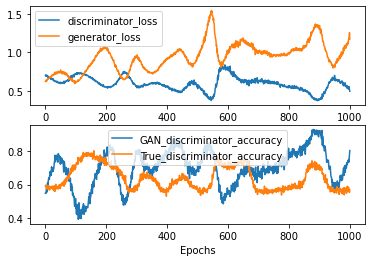

8/8 [==============================] - 0s 5ms/step


C:\Windows\Temp\ipykernel_15832\2783495971.py:131: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  noise_x = pd.DataFrame(noiseupsampled_x).append(pd.DataFrame(withnoise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:132: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  noise_y = pd.DataFrame(noiseupsampled_y).append(pd.DataFrame(withnoise_y),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:136: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis2x_final = pd.DataFrame(noise_x).append(pd.DataFrame(nonoise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_15832\2783495971.py:137: FutureWarning: The frame.append method is deprecated and will be removed from pa

Final True Discriminant Accuracy: 0.652


In [23]:
#train the model
train(gen,disc,disc2,gan,predprobnoise,predprobtrue,n_epochs = 1000)

Model the accuracy pattern is the same because the discriminator for the GAN and the True discriminator uses the same optimizer and same loss function. Or is it because the distribution of fake input to train disc2 and to train disc is the same?

In [24]:
genafter = gen.predict(noise)
print(genafter)

188/188 [==============================] - 0s 2ms/step
[[ 0.10851522  0.16088912  0.86466026 ... -0.56775814  0.735815
  -0.06447561]
 [-0.18181032  0.14526692  0.04874427 ... -0.06598242  0.01681415
  -0.02696841]
 [-0.11960681  0.22853698  0.07305237 ... -0.05155322  0.04907596
  -0.01938805]
 ...
 [-0.07082261  0.94914526  0.22520976 ...  0.00896101  0.6511404
  -0.28231722]
 [ 0.04350407 -0.12388627  0.80793595 ... -0.30783722  0.5349276
  -0.04181775]
 [-0.01255511  0.10632731  0.49283123 ... -0.24256791  0.38901952
  -0.05727974]]


In [25]:
import seaborn as sns
comparenoise = predprobnoise.flatten()
comparetrue = predprobtrue.flatten()

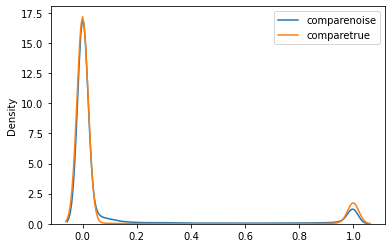

In [26]:
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()

In [27]:
coba1 = np.ones((128,1))
coba2 = np.zeros((128,1))

coba3 = pd.DataFrame(coba1).append(pd.DataFrame(coba2),ignore_index = True).to_numpy()
coba3.shape

C:\Windows\Temp\ipykernel_15832\3163085887.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coba3 = pd.DataFrame(coba1).append(pd.DataFrame(coba2),ignore_index = True).to_numpy()


(256, 1)

In [28]:
coba3[:] = 1

In [29]:
print(np.unique(coba3))
print(coba3.shape)

[1.]
(256, 1)
